# Compile datasets

## Prepares LAI and climate data sets for LSTM model

- converts terraclim tifs to an xarray data set
- merges LAI and climate data sets
- masks with the Hansen forest mask
- clips to Madre de Dios region

## Setup

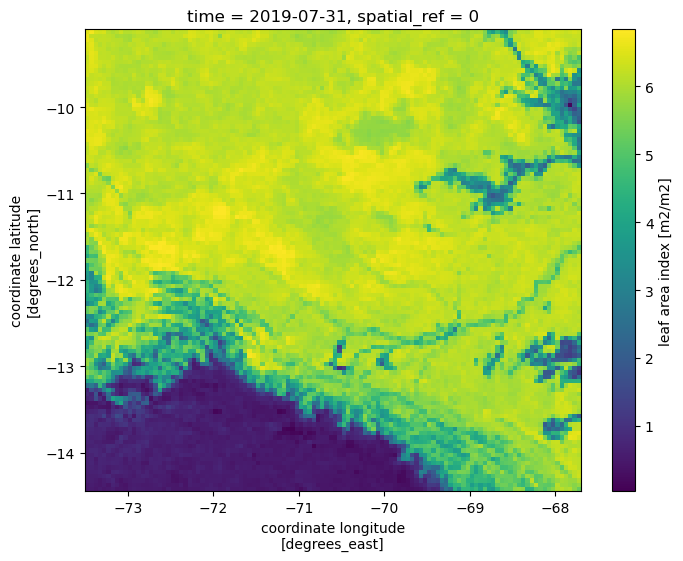

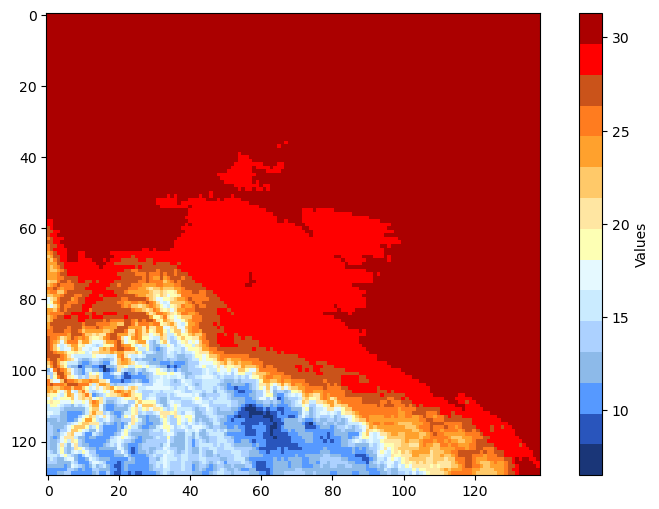

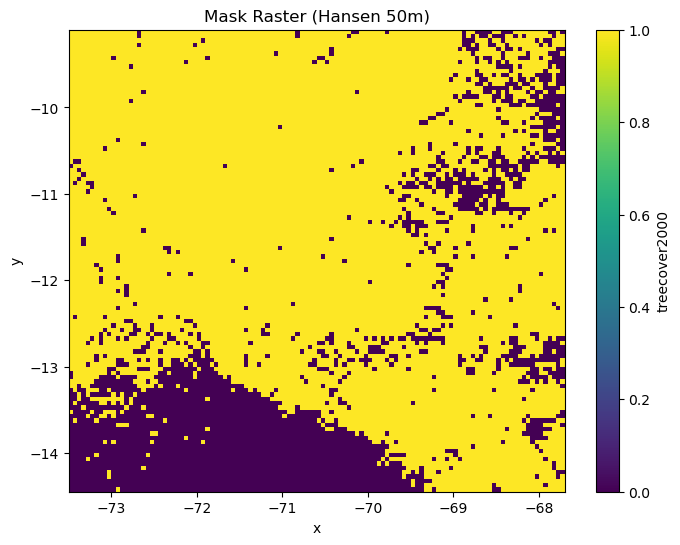

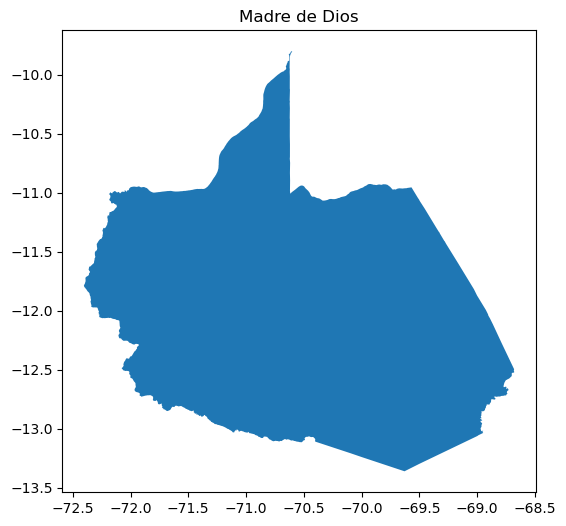

In [1]:
# import packages
import xarray as xr
import rioxarray as rio
import numpy as np
import geopandas as gpd
import pandas as pd
import os
import glob
import rasterio
import re
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from rasterio.enums import Resampling 

# load in data
# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------

# LAI netCDF
# --------------------------

# set path
lai_path = "/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/modisLAI/MODIS_LAI_monthly.nc"
# import
lai_xr = xr.open_dataset(lai_path)

# Set spatial dimensions and CRS
lai_xr = lai_xr.rio.set_spatial_dims(x_dim="lon", 
                                     y_dim="lat", 
                                     inplace=False)
lai_xr = lai_xr.rio.write_crs("EPSG:4326", 
                              inplace=True) 

# print some stuff out to check
# print("LAI:", lai_xr) #full data set
# print("CRS:", lai_xr['lai'].rio.crs) #crs
# print("dimensions:", lai_xr['lai'].dims) #dimensions
# print("time steps:", lai_xr.time.values)  # dates

# plot
lai_xr.lai.isel(time=210).plot(figsize=(8,6))

# Climate tifs
# --------------------------

# set path
clim_path = "/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/"
# import tif filepaths as a list
clim_tifs = sorted(glob.glob(os.path.join(clim_path, "*.tif")))

#  print some stuff out to check
# climTest_tif = rio.open_rasterio("/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_01.tif")
# print("Clim:", climTest_tif) #full data set
# print("CRS:", climTest_tif.rio.crs) #crs

# plot
# Open raster 
with rasterio.open("/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_01.tif") as src:
    raster = src.read(1)          # read first band
# Define color palette
palette = [
    '#1a3678', '#2955bc', '#5699ff', '#8dbae9', '#acd1ff', '#caebff', '#e5f9ff',
    '#fdffb4', '#ffe6a2', '#ffc969', '#ffa12d', '#ff7c1f', '#ca531a', '#ff0000',
    '#ab0000'
]
# Visualize
plt.figure(figsize=(10, 6))
plt.imshow(raster, cmap=ListedColormap(palette))
plt.colorbar(label='Values')
plt.show()

# Hansen mask tif
# --------------------------

# import file
forest_tif = rio.open_rasterio("/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/hansenMask_mode_5km_v2.tif")

# squeeze band dimension if neeed
if 'band' in forest_tif.dims and forest_tif.sizes['band'] == 1:
    forest_tif = forest_tif.squeeze('band')

# visualize
forest_tif.plot(figsize=(8, 6))
plt.title("Mask Raster (Hansen 50m)")
plt.show()

# Madre de Dios geoJSON
# --------------------------

# import and set crs
mdd_gjson = gpd.read_file("/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/MDD_political_boundary.geojson").to_crs("EPSG:4326")

mdd_gjson.plot(figsize=(8, 6))
plt.title("Madre de Dios")
plt.show()


In [99]:
# example = glob.glob("/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/*.tif")[1]

# with rasterio.open(example) as src:
#     print("CRS:", src.crs)
#     print("Resolution:", src.res)
#     print("Bounds:", src.bounds)

# da = rio.open_rasterio("/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_01.tif")
# print(da.rio.crs)
# print(da)

## Compile Climate Data

In [100]:
# convert terraclim tifs into an xarray data set

# sort climate tifs into a dictionary
# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------

# create a dictionary of all bands and the xarrays belonging to them for each time step

# create a dictionary to hold each band's xarrays
# Keys = band names (e.g., "band1", "band2")
# Values = list of xarrays (one per time step)
bands_dict = {}  
# create a list to hold time stamps corresponding to each tif
timestamps_list = [] 

# iterate through all the climate tif filepaths
for f in clim_tifs:

    # create time steps
    # --------------------------
    
    # get just the filename
    name_full = os.path.basename(f)
    
    # remove ".tif" and split by "_" to isolate year and month, get a list of 
    # example: "climate_2005_03.tif" -> ["terraClim", "2005", "03"]
    name_parts = name_full.replace(".tif", "").split("_")
    # print(name_parts)

    # convert extracted year and month into integers
    year, month = int(name_parts[1]), int(name_parts[2])
    # print(year, month)

    # create a time stamp that gives it the last day of the month
    # example: 2005, 03 → 2005-03-31
    time_stamp = pd.Timestamp(year=year, month=month, day=1) + pd.offsets.MonthEnd(0)
    # print(time_stamp)

    # store the time stamps for later
    timestamps_list.append(time_stamp)

    # create xarray
    # --------------------------
    
    # load the tif 
    ds = rio.open_rasterio(f, masked=True)
    
    # loop through each band
    for band in range(ds.sizes['band']):

        # create a band name for each band
        band_name = f"band{band+1}"
        # print(band_name)

        # extract the specific band as an xarray dataset
        band_xr = ds.isel(band=band)

        # add a new time dimension, with this band's time stamp
        band_xr = band_xr.expand_dims({'time': [time_stamp]})
        # print(band_xr)
        
        # if the band name is already an item in the bands dictionary, append this time step for that band
        if band_name in bands_dict:
            bands_dict[band_name].append(band_xr)
        # if not, initialize the dictionary item for that band 
        else:
            bands_dict[band_name] = [band_xr]

# print
# print(bands_dict)
# print(timestamps_list)

# combine into one xarray
# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------

# Combine each list of xarrays into one xarray with many data variables

# create a dictionary to hold all the xarrays
# Keys = band names (e.g., "band1", "band2")
# Values = xarrays 
ds_dict = {}

# loop through the dictionary that contains lists of xarrays per band
for band_name, ds_list in bands_dict.items():

    # For each tif in the list, drop the 'band' coordinate if it exists 
    cleaned_list = [
        ds.drop_vars('band', errors='ignore')   # remove "band" dimension safely
        for ds in ds_list
    ]

    # Concatenate all time slices for this band along the time dimension
    # Produces a single (time, y, x) xarray for each variable
    ds_dict[band_name] = xr.concat(cleaned_list, dim='time')

# Create the final xarray by combining all the bands' individual xarrays 
clim_xr = xr.Dataset(ds_dict)

# Print the final structured Dataset
print(clim_xr)

/srv/conda/envs/notebook/lib/python3.12/site-packages/rioxarray/_io.py:1146: RuntimeWarning: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
  if riods.subdatasets:
/srv/conda/envs/notebook/lib/python3.12/site-packages/rioxarray/_io.py:1146: RuntimeWarning: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
  if riods.subdatasets:
/srv/conda/envs/notebook/lib/python3.12/site-packages/rioxarray/_io.py:1146: RuntimeWarning: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
  if riods.subdatasets:
/srv/conda/envs/notebook/lib/python3.12/site-packages/rioxarray/_io.py:1146: RuntimeWarning: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples 

<xarray.Dataset> Size: 304MB
Dimensions:      (time: 300, x: 139, y: 130)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2000-01-31 2000-02-29 ... 2024-12-31
  * x            (x) float64 1kB -73.48 -73.44 -73.4 ... -67.81 -67.77 -67.73
  * y            (y) float64 1kB -9.104 -9.146 -9.187 ... -14.4 -14.44 -14.48
    spatial_ref  int64 8B 0
Data variables:
    band1        (time, y, x) float64 43MB 31.2 31.1 31.0 ... 31.9 31.9 31.7
    band2        (time, y, x) float64 43MB 21.4 21.3 21.2 ... 22.9 22.8 22.7
    band3        (time, y, x) float64 43MB 134.0 134.0 136.0 ... 170.0 172.0
    band4        (time, y, x) float64 43MB -1.59 -1.6 -1.59 ... -6.87 -6.89
    band5        (time, y, x) float64 43MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    band6        (time, y, x) float64 43MB 0.8 0.79 0.78 0.78 ... 1.08 1.08 1.06
    band7        (time, y, x) float64 43MB 157.7 156.9 156.0 ... 84.5 85.1 84.9


## Prepare Climate Data

<xarray.Dataset> Size: 158MB
Dimensions:      (time: 228, lon: 116, lat: 107)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lon          (lon) float32 464B -73.47 -73.42 -73.38 ... -67.78 -67.72
  * lat          (lat) float32 428B -9.125 -9.175 -9.225 ... -14.38 -14.43
    spatial_ref  int64 8B 0
Data variables:
    tmmx         (time, lat, lon) float64 23MB 32.1 32.0 31.9 ... 31.1 31.2 31.1
    tmmn         (time, lat, lon) float64 23MB 22.2 22.2 22.1 ... 22.0 22.1 21.9
    pr           (time, lat, lon) float64 23MB 359.0 361.0 370.0 ... 392.0 399.0
    pdsi         (time, lat, lon) float64 23MB -1.68 -1.65 -1.57 ... -2.09 -2.06
    def          (time, lat, lon) float64 23MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    vpd          (time, lat, lon) float64 23MB 0.89 0.88 0.87 ... 0.93 0.94 0.93
    soil         (time, lat, lon) float64 23MB 156.8 156.0 154.5 ... 234.9 229.8
bounds: (-73.4999984741211, -14.450001140810409, -67.69999847412109, -

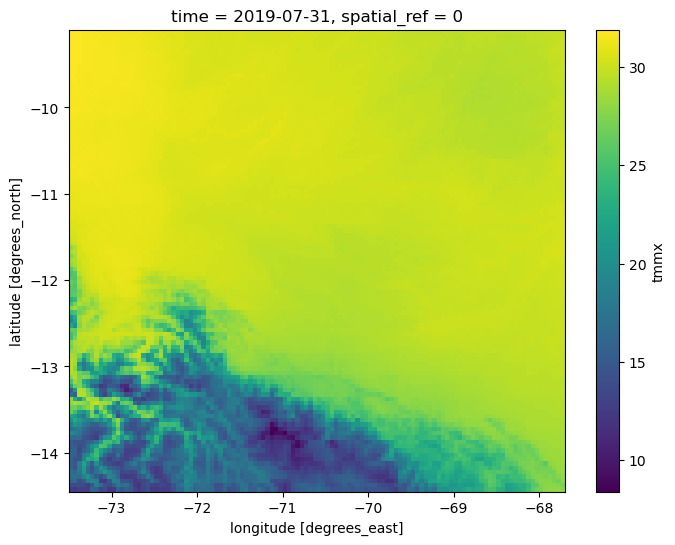

In [101]:
# rename bands
# --------------------------

# create a list of new band names
names_list = ['tmmx', 'tmmn', 'pr', 'pdsi', 'def', 'vpd', 'soil']

# Create a mapping from old names to new names
rename_dict = {f'band{i+1}': name for i, name in enumerate(names_list)}

# Rename the data variables (including spatial dimensions to match those of LAI)
clim_xr_renamed = clim_xr.rename(rename_dict).rename({'x': 'lon', 'y': 'lat'})


# clip time extent
# --------------------------

# clip the time extent of climate to that of LAI so they have the exact same time steps

# Ensure both are in pd.DatetimeIndex format
lai_timestamps_list = pd.to_datetime(lai_xr.time.values)
clim_timestamps_list = pd.to_datetime(clim_xr_renamed.time.values)

# Select only TerraClim time stamps within LAI range
start_time = lai_timestamps_list.min()
end_time = lai_timestamps_list.max()

# clip climate time steps to LAI time steps
clim_xr_timeClip = clim_xr_renamed.sel(time=slice(start_time, end_time))

# reproject
# --------------------------

# Define  which dimensions represent spatial coordinates
clim_xr_spatDim = clim_xr_timeClip.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

# reproject and resample to match the crs and dimesnions of LAI
clim_xr_spatDim.rio.write_crs(lai_xr.rio.crs, inplace=True)
# clim_xr_reproj = clim_xr_spatDim.rio.reproject("EPSG:4326")
clim_xr_reproj = clim_xr_spatDim.rio.reproject_match(lai_xr).rename({'x': 'lon', 'y': 'lat'})

# check
# --------------------------

# full data set
print(clim_xr_reproj) 

# time values
# print(clim_xr_timeClip.time.values)

#bounds
print('bounds:',clim_xr_reproj.rio.bounds()) 
print('bounds:',lai_xr.rio.bounds())

#crs
print('CRS:',lai_xr['lai'].rio.crs) 
print('CRS:',clim_xr_reproj['tmmx'].rio.crs)

# pixel resolution
dx = float(clim_xr_reproj['lon'][1] - clim_xr_reproj['lon'][0])
dy = float(clim_xr_reproj['lat'][1] - clim_xr_reproj['lat'][0])
print(f"Pixel size in x (lon): {dx} degrees")
print(f"Pixel size in y (lat): {dy} degrees")
dx = float(lai_xr['lon'][1] - lai_xr['lon'][0])
dy = float(lai_xr['lat'][1] - lai_xr['lat'][0])
print(f"Pixel size in x (lon): {dx} degrees")
print(f"Pixel size in y (lat): {dy} degrees")

# plot
clim_xr_reproj.tmmx.isel(time=210).plot(figsize=(8,6))


## Merge Climate and LAI Data

<xarray.Dataset> Size: 181MB
Dimensions:      (time: 228, lon: 116, lat: 107)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lon          (lon) float32 464B -73.47 -73.42 -73.38 ... -67.78 -67.72
  * lat          (lat) float32 428B -9.125 -9.175 -9.225 ... -14.38 -14.43
    spatial_ref  int64 8B 0
Data variables:
    tmmx         (time, lat, lon) float64 23MB 32.1 32.0 31.9 ... 31.1 31.2 31.1
    tmmn         (time, lat, lon) float64 23MB 22.2 22.2 22.1 ... 22.0 22.1 21.9
    pr           (time, lat, lon) float64 23MB 359.0 361.0 370.0 ... 392.0 399.0
    pdsi         (time, lat, lon) float64 23MB -1.68 -1.65 -1.57 ... -2.09 -2.06
    def          (time, lat, lon) float64 23MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    vpd          (time, lat, lon) float64 23MB 0.89 0.88 0.87 ... 0.93 0.94 0.93
    soil         (time, lat, lon) float64 23MB 156.8 156.0 154.5 ... 234.9 229.8
    lai          (time, lat, lon) float64 23MB ...
bounds: (-73.499998

/tmp/ipykernel_2327/2930696799.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  combo_climLAI_xr = xr.merge([clim_xr_reproj, lai_xr])


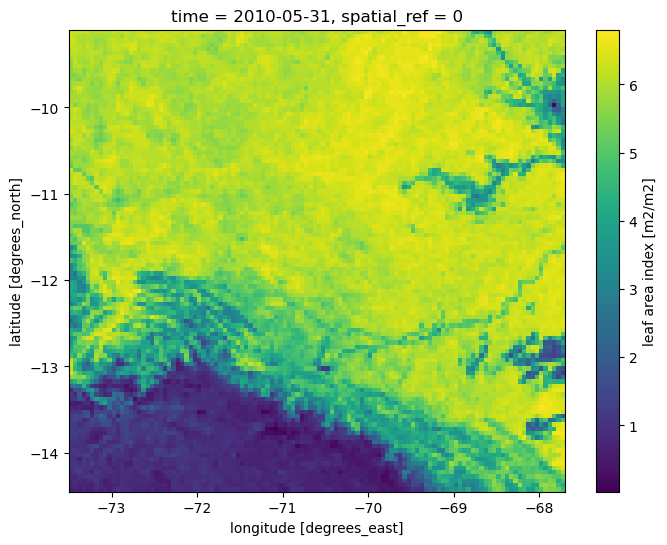

In [102]:
# merge data sets
combo_climLAI_xr = xr.merge([clim_xr_reproj, lai_xr])

# print some info
print(combo_climLAI_xr)
# print(combo_climLAI_xr.time.values) # time values
print('bounds:',combo_climLAI_xr.rio.bounds()) #bounds
print('CRS:',combo_climLAI_xr['lai'].rio.crs) #crs

# calculate pixel resolution
# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------

# degrees
# --------------------------

dx = float(combo_climLAI_xr['lon'][1] - combo_climLAI_xr['lon'][0]) # longitude spacing between pixels (degrees)
dy = float(combo_climLAI_xr['lat'][1] - combo_climLAI_xr['lat'][0]) # latitude spacing between pixels (degrees)
print(f"Pixel size in x (lon): {dx} degrees")
print(f"Pixel size in y (lat): {dy} degrees")

# meters
# --------------------------

lat = float(combo_climLAI_xr['lat'].mean())  # mean latitude of the dataset
dx_m = dx * 111320 * np.cos(np.deg2rad(lat))  # convert lon degrees to meters using cosine(latitude)
dy_m = dy * 111320                             # convert lat degrees to meters (constant conversion)
print(f"Pixel size in x: {dx_m:.2f} meters")
print(f"Pixel size in y: {dy_m:.2f} meters")

# plot
combo_climLAI_xr.lai.isel(time=100).plot(figsize=(8,6))

## Export (Optional)

In [103]:
# # Export to a netCDF (optional)
# output_path = "/home/jovyan/large_files/climLai_merged.nc"
# combo_climLAI_xr.to_netcdf(output_path)

## Reimport (Optional)

In [60]:
# # reimport (optional)
# combo_climLAI_xr = xr.open_dataset("/home/jovyan/large_files/climLai_merged.nc")

# # set a crs (somehow it loses this when you export as a netCDF)
# if combo_climLAI_xr.rio.crs is None:
#     combo_climLAI_xr = combo_climLAI_xr.rio.write_crs("EPSG:4326")

# # print some info
# print(combo_climLAI_xr)
# print(combo_climLAI_xr['lai'].rio.crs)
# print(combo_climLAI_xr['lai'].dims)
# # print(combo_climLAI_xr.time.values)

# # plot
# # combo_climLAI_xr.lai.isel(time=210).plot(figsize=(8,6))

<xarray.Dataset> Size: 181MB
Dimensions:      (time: 228, lat: 107, lon: 116)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat          (lat) float32 428B -9.125 -9.175 -9.225 ... -14.38 -14.43
  * lon          (lon) float32 464B -73.47 -73.42 -73.38 ... -67.78 -67.72
    spatial_ref  int64 8B 0
Data variables:
    tmmx         (time, lat, lon) float64 23MB ...
    tmmn         (time, lat, lon) float64 23MB ...
    pr           (time, lat, lon) float64 23MB ...
    pdsi         (time, lat, lon) float64 23MB ...
    def          (time, lat, lon) float64 23MB ...
    vpd          (time, lat, lon) float64 23MB ...
    soil         (time, lat, lon) float64 23MB ...
    lai          (time, lat, lon) float64 23MB ...
EPSG:4326
('time', 'lat', 'lon')


## Prepare Forest Mask

('y', 'x')
<xarray.Dataset> Size: 3MB
Dimensions:     (time: 228, lat: 107, lon: 116)
Coordinates:
  * time        (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat         (lat) float32 428B -9.125 -9.175 -9.225 ... -14.33 -14.38 -14.43
  * lon         (lon) float32 464B -73.47 -73.42 -73.38 ... -67.82 -67.78 -67.72
Data variables:
    forestMask  (time, lat, lon) uint8 3MB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1


/tmp/ipykernel_2327/742731324.py:20: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  np.broadcast_to(forest_tif.values, (combo_climLAI_xr.dims['time'], *forest_tif.shape)),


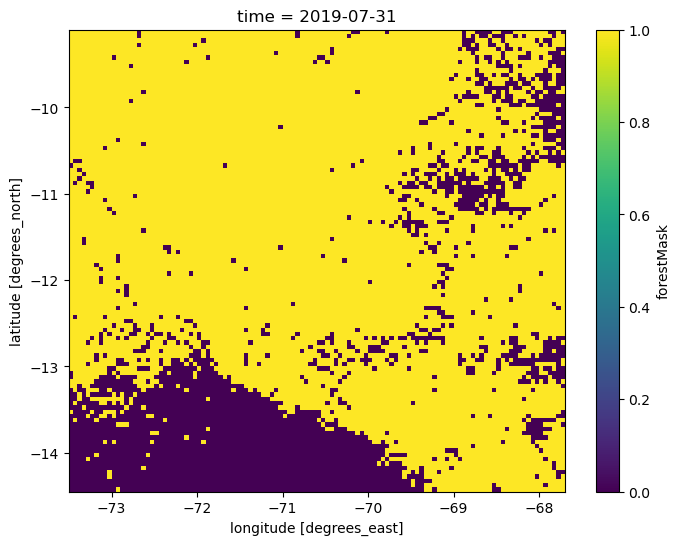

In [73]:
# print some info

# print("combo_climLAI_xr CRS:", combo_climLAI_xr.rio.crs)
# print("combo_climLAI_xr transform:", combo_climLAI_xr.rio.transform())
# print("combo_climLAI_xr pixel size:", combo_climLAI_xr.rio.resolution())
# print("combo_climLAI_xr shape:", combo_climLAI_xr.rio.shape)

# print("mask CRS:", forest_tif.rio.crs)
# print("mask transform:", forest_tif.rio.transform())
# print("mask pixel size:", forest_tif.rio.resolution())
# print("mask shape:", forest_tif.rio.shape)

print(forest_tif.dims)

# convert to xarray with same time dimension 
# --------------------------

# convert to an xarray
forest_xr = xr.DataArray(
    np.broadcast_to(forest_tif.values, (combo_climLAI_xr.dims['time'], *forest_tif.shape)),
    # add on time, lat, lon dimensions according to those in the combined LAI/climate xarray
    coords={
        "time": combo_climLAI_xr.time,
        "lat": combo_climLAI_xr.lat,
        "lon": combo_climLAI_xr.lon
    },
    dims=("time", "lat", "lon")
)

# add a name for the data variable
forest_xr = xr.Dataset({"forestMask": forest_xr})

# print + plot
print(forest_xr)
forest_xr.forestMask.isel(time=210).plot(figsize=(8,6))


## Merge Forest Mask to Climate/LAI Data

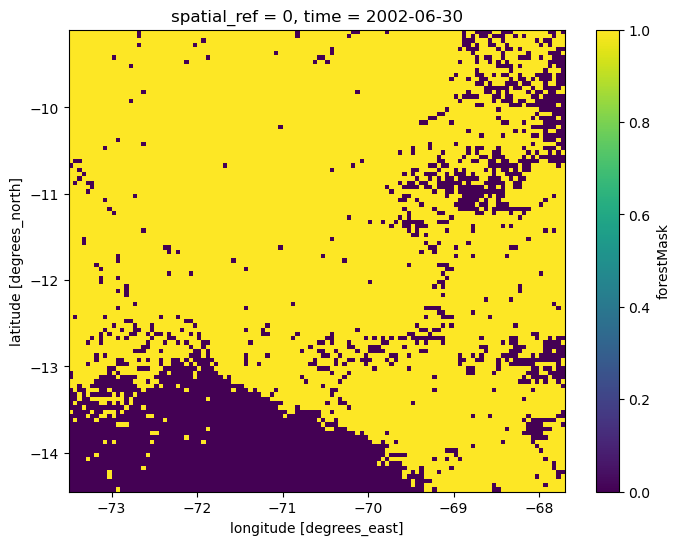

In [89]:
# merge
combo_climLAIforest_xr = xr.merge([combo_climLAI_xr, forest_xr])

# check
combo_climLAIforest_xr
combo_climLAIforest_xr.forestMask.isel(time=5).plot(figsize=(8,6))

## Mask to Continuous Forest

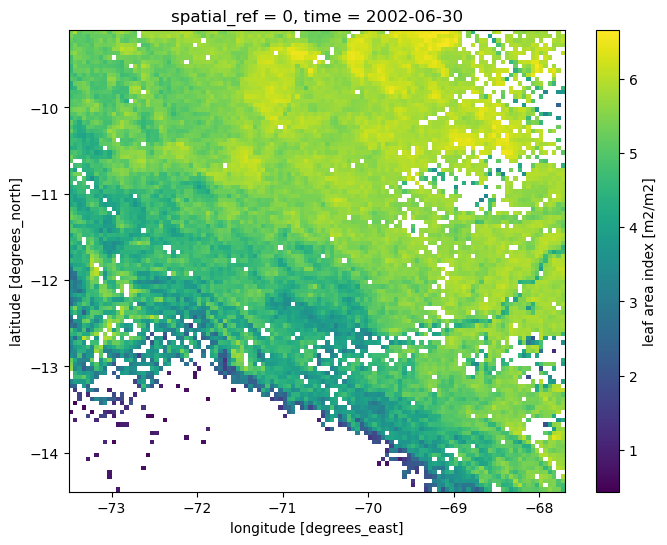

In [96]:
# create a mask where forest was continuous over time period
mask = combo_climLAIforest_xr["forestMask"] > 0

# create a dictionary to store each data variable after masking
maskedVars_dict = {}

# iterate through the climate/LAI xarray's data variables
for var in combo_climLAIforest_xr.data_vars:
    # skip the mask
    if var != "forestMask":  
        # mask the data variable and add it to the masked variable dictionary
        maskedVars_dict[var] = combo_climLAIforest_xr[var].where(mask)

# create an xarray from the dictionary
combo_climLAI_masked_xr = xr.Dataset(maskedVars_dict, coords=combo_climLAIforest_xr.coords)

# plot
combo_climLAI_masked_xr.lai.isel(time=5).plot(figsize=(8,6))

## Export (Optional)

In [92]:
# output_path = "/home/jovyan/large_files/climLai_masked_v2.nc"
# combo_climLAI_masked_xr.to_netcdf(output_path)

## Reimport (Optional)

<xarray.Dataset> Size: 181MB
Dimensions:      (time: 228, lat: 107, lon: 116)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat          (lat) float32 428B -9.125 -9.175 -9.225 ... -14.38 -14.43
  * lon          (lon) float32 464B -73.47 -73.42 -73.38 ... -67.78 -67.72
    spatial_ref  int64 8B ...
Data variables:
    tmmx         (time, lat, lon) float64 23MB ...
    tmmn         (time, lat, lon) float64 23MB ...
    pr           (time, lat, lon) float64 23MB ...
    pdsi         (time, lat, lon) float64 23MB ...
    def          (time, lat, lon) float64 23MB ...
    vpd          (time, lat, lon) float64 23MB ...
    soil         (time, lat, lon) float64 23MB ...
    lai          (time, lat, lon) float64 23MB ...
EPSG:4326
('time', 'lat', 'lon')


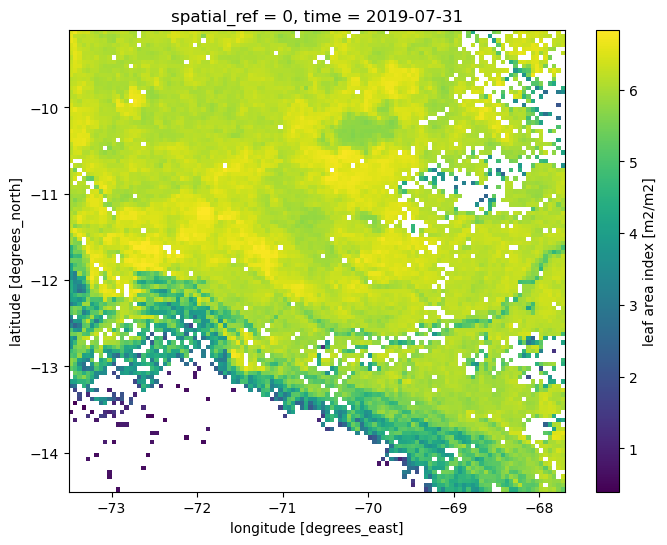

In [104]:
# # reimport (optional)
# combo_climLAI_masked_xr = xr.open_dataset("/home/jovyan/large_files/climLai_masked_v2.nc")

# # set a crs (somehow it loses this when you export as a netCDF)
# if combo_climLAI_masked_xr.rio.crs is None:
#     combo_climLAI_masked_xr = combo_climLAI_masked_xr.rio.write_crs("EPSG:4326")

# # print some info
# print(combo_climLAI_masked_xr)
# print(combo_climLAI_masked_xr['lai'].rio.crs)
# print(combo_climLAI_masked_xr['lai'].dims)
# # print(combo_climLAI_masked_xr.time.values)

# # plot
# combo_climLAI_masked_xr.lai.isel(time=210).plot(figsize=(8,6))

## Clip to Madre de Dios

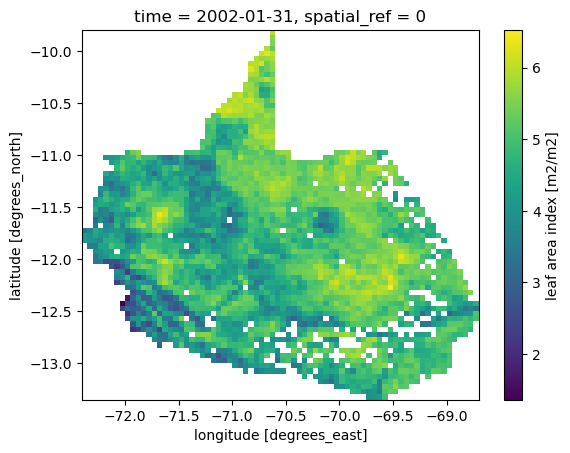

In [105]:
# clip
combo_climLAI_maskedClipped_xr = combo_climLAI_masked_xr.rio.clip(
    mdd_gjson.geometry,
    mdd_gjson.crs,
    drop=True
)

# plot
combo_climLAI_maskedClipped_xr["lai"].isel(time=0).plot()

## Export

In [107]:
output_path = "/home/jovyan/large_files/climLai_masked_v3.nc"
combo_climLAI_maskedClipped_xr.to_netcdf(output_path)